## Minimum code for plotting translation-dependency of codon/amino acid effects

### Load libraries

In [165]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(ggh4x))
suppressPackageStartupMessages(library(plotrix))

n_barcodes_cutoff <- 2
barcode_reads_cutoff <- 10 
umi_count_cutoff <- 10

### Global plotting themes

In [166]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

In [167]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

### Read insert annotations & insert-barcode linkages

In [168]:
insert_annotations <- read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv", show_col_types = F) %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert)

head(insert_annotations)

insert_num,dicodon,diaa,codon1,codon2,aa1,aa2
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0,AAAAAA,KK,AAA,AAA,K,K
1,AAAAAC,KN,AAA,AAC,K,N
2,AAAAAG,KK,AAA,AAG,K,K
3,AAAAAT,KN,AAA,AAT,K,N
4,AAAACA,KT,AAA,ACA,K,T
5,AAAACC,KT,AAA,ACC,K,T


In [169]:
insert_barcode_linkages <- read_csv("../../8xdicodon_linkage/data/filtered_barcodes/yeast_cyto_linkage.csv") %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(linkage_count = as.numeric(linkage_count)) %>%
  mutate(linkage_ref = 'yeast_cyto_linkage')

head(insert_barcode_linkages)

Rows: 2455063 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


insert_num,barcode_num,barcode,linkage_count,linkage_ref
<dbl>,<dbl>,<chr>,<dbl>,<chr>
NA,1,barcode,NA,yeast_cyto_linkage
4457,2,GGGCTTAAGAAGATCCTTGTCAGG,99,yeast_cyto_linkage
4123,3,TAGCACATTTCCTCTGGGGTTCGT,99,yeast_cyto_linkage
4793,4,TACTGTTTTGCTCGTGGCGTTTAT,99,yeast_cyto_linkage
180,5,GAGAGGTGGATCGCGCACAGCAAG,99,yeast_cyto_linkage
4969,6,GGGGTGTATAGGACCGGCCAGTCT,99,yeast_cyto_linkage


## Plot frame effects for WT and Hel2-del (no-tx) data

### Read annotations & barcode counts for WT no-tx mRNA/gRNA

In [170]:
sample_annotations_51 = read_csv("../../wt_mrna_grna/annotations/sample_annotations.csv", comment='#')
sample_annotations_51

Rows: 2 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (3): barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


owner,sample_type,sample_name,plasmid,library_type,illumina_sample_id,sample_id,barcode_read,barcode_start,barcode_length,linkage_ref,r1_file,r2_file,s3,shared
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kc,dicodon_yeast,wt_gdna,pHPSC1142,grna,51lib2,51lib2,1,1,24,yeast_cyto_linkage,kc_51lib2_S13_R1_001,kc_51lib2_S13_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/
kc,dicodon_yeast,wt_mrna,pHPSC1142,mrna,51lib1,51lib1,1,1,24,yeast_cyto_linkage,kc_51lib1_S12_R1_001,kc_51lib1_S12_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/


In [171]:
barcode_counts_51 <- list.files("../../wt_mrna_grna/data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 197785 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 172594 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [172]:
barcode_insert_counts_51 <- barcode_counts_51 %>% 
  left_join(select(sample_annotations_51, c(sample_id, sample_name)), by = "sample_name") %>%
  left_join(insert_barcode_linkages, by = c("barcode_num", "barcode", "insert_num", "linkage_count")) %>%
  drop_na(barcode_count) %>%
  select(-sample_id)

head(barcode_insert_counts_51)

barcode_count,insert_num,barcode_num,barcode,linkage_count,sample_name,linkage_ref
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
4871,186,1643847,AGTCGTTGTAGCAACTCGATGTTT,16,wt_gdna,yeast_cyto_linkage
4653,5658,1596380,CTGGATGTCGCGAGCAACAACAGC,17,wt_gdna,yeast_cyto_linkage
3823,5810,764917,TGTATTCGGGCCAGCATGAGGTGC,4,wt_gdna,yeast_cyto_linkage
3656,2787,1040412,AGCGATTAGAGCATTTCTGGCCAC,3,wt_gdna,yeast_cyto_linkage
3577,203,1644177,TGGGATCTTTTCGCGTATTCGGTT,16,wt_gdna,yeast_cyto_linkage
3497,4868,692986,TCGCTCCGTGTCGTGTCTCCTATG,4,wt_gdna,yeast_cyto_linkage


### Read annotations & barcode counts for Hel2-del no-tx mRNA/gRNA

In [173]:
sample_annotations_67 = read_csv("../../hel2_syh1_mrna_grna/annotations/sample_annotations.csv", comment='#')
sample_annotations_67

Rows: 6 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (3): barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


owner,sample_type,sample_name,plasmid,library_type,illumina_sample_id,sample_id,srr,barcode_read,barcode_start,barcode_length,linkage_ref,r1_file,r2_file,r3_file,i1_file
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kc,dicodon_yeast,hel2_mrna,pHPSC1142,mrna,67lib1-2,67lib1,SRR24831409,1,1,24,yeast_cyto_linkage,kc_67lib1-2_S1_R1_001,kc_67lib1-2_S1_R2_001,NA,NA
kc,dicodon_yeast,hel2_gdna,pHPSC1142,grna,67lib3-2,67lib3,SRR24831408,1,1,24,yeast_cyto_linkage,kc_67lib3-2_S3_R1_001,kc_67lib3-2_S3_R2_001,NA,NA
kc,dicodon_yeast,hel2_mrna_reseq,pHPSC1142,mrna,67lib1-2,67lib1,SRR24725021,1,7,24,yeast_cyto_linkage,kc_67lib1_2_S6_R1_001,kc_67lib1_2_S6_R2_001,kc_67lib1_2_S6_R3_001,kc_67lib1_2_S6_I1_001
kc,dicodon_yeast,hel2_gdna_reseq,pHPSC1142,grna,67lib3-2,67lib3,SRR24725019,1,7,24,yeast_cyto_linkage,kc_67lib3_2_S7_R1_001,kc_67lib3_2_S7_R2_001,kc_67lib3_2_S7_R3_001,kc_67lib3_2_S7_I1_001
kc,dicodon_yeast,syh1_mrna,pHPSC1142,mrna,67lib2-2,67lib2,SRR24725020,1,1,24,yeast_cyto_linkage,kc_67lib2-2_S2_R1_001,kc_67lib2-2_S2_R2_001,NA,NA
kc,dicodon_yeast,syh1_gdna,pHPSC1142,grna,67lib4-2,67lib4,SRR24725018,1,1,24,yeast_cyto_linkage,kc_67lib4-2_S4_R1_001,kc_67lib4-2_S4_R2_001,NA,NA


In [174]:
barcode_counts_67 <- list.files("../../hel2_syh1_mrna_grna/data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count)) %>%
  mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
  mutate(library_type = str_extract(sample_name, '(?<=_).+')) %>%
  mutate(library_type = ifelse(str_detect(library_type, 'reseq'), str_extract(sample_name, '(?<=_).+(?=_)'), library_type)) %>%
  select(genotype, library_type, barcode_num, insert_num, barcode_count) %>%
  group_by(genotype, library_type, barcode_num, insert_num) %>% # combine resequenced counts together
  summarize(barcode_count = sum(barcode_count), .groups='drop')

Rows: 99948 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 163535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 110997 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the colu

### Plot WT frame effects

In [175]:
insert_reads_cutoff <- 500
n_barcodes_cutoff <- 2
barcode_reads_cutoff <- 10
AMINO_ACID_CODE["*"] = "*"

dicodon_lfc_51 <- barcode_insert_counts_51 %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n(), .groups='drop') %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(dicodon, diaa, aa1, aa2, sample_name) %>%
  summarize(count = sum(count), n_barcodes = sum(n_barcodes), .groups='drop') %>%
  ungroup() %>%
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>%
  filter((count_wt_gdna >= insert_reads_cutoff) & (count_wt_mrna >= insert_reads_cutoff)) %>%
  filter((n_barcodes_wt_gdna >= n_barcodes_cutoff) & (n_barcodes_wt_mrna >= n_barcodes_cutoff)) %>%
  mutate(lfc = log2(count_wt_mrna) - log2(count_wt_gdna)) %>%
  drop_na(lfc) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc)

In [176]:
diaa_allframe_lfc_51 <- dicodon_lfc_51 %>% 
  crossing(frame = c("frame" = seq(0,5))) %>%
  select(-lfc, -diaa, -aa1, -aa2) %>%
  mutate(dicodon = substr(paste0(dicodon, dicodon), frame + 1, 6 + frame)) %>%
  mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
  select(-dicodon) %>%
  group_by(diaa, frame) %>%
  summarize_all(sum) %>%
  ungroup() %>%
  mutate(lfc = log2(count_wt_mrna / count_wt_gdna)) %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  select(diaa, frame, lfc, lfc_2) %>%
  complete(diaa, frame)

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


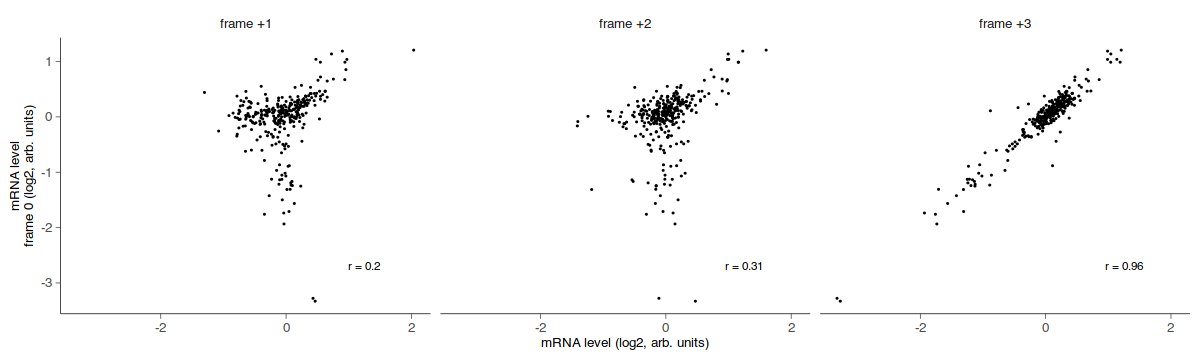

In [177]:
options(repr.plot.width = 10, repr.plot.height = 3)

plot_data <- diaa_allframe_lfc_51 %>% 
  # filter(!diaa %in% wt_missing_diaa) %>% 
  group_by(diaa) %>% 
  mutate(frame0_lfc = lfc_2[frame == 0]) %>% 
  ungroup() %>% 
  filter(length(frame0_lfc) != 0) %>%
  filter(frame %in% c(1,2,3)) %>% 
  mutate(frame = paste0("+", frame)) %>% 
  filter(!str_detect(diaa, "\\*")) %>% 
  mutate(aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
  drop_na()
  # filter(aa1 > aa2)

label_data <- plot_data %>% 
  group_by(frame) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~frame0_lfc + lfc_2, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r = ", round(estimate, 2)))

plot_data %>% 
  ggplot(aes(x = lfc_2, y = frame0_lfc)) +
  facet_wrap(~ frame, ncol = 5, labeller = as_labeller(. %>% paste("frame", .))) +
  geom_point(size = 0.2) +
  # annotate('text',x = 0.8, y = -2.7, size=8/.pt, label = estimate, data = label_data) +
  geom_text(aes(label = estimate), x = 1.25, y = -2.7, data = label_data, size=7/.pt) +
  theme + 
  theme(strip.background = element_blank(),
        strip.text.x = element_text(size = 8)) + 
  labs(x = "mRNA level (log2, arb. units)", y = "mRNA level\nframe 0 (log2, arb. units)")

ggsave("../figures/wt_frame_effects_rm_missing.pdf", width=3.5, height=1.6)

In [128]:
plot_data %>%
    group_by(diaa) %>%
    summarize(n()) %>%
    nrow()

[1] 320

## Plot glucose deprivation data

### Read sample annotations for glucose deprivation experiment

In [129]:
sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment='#', show_col_types = F) %>%
    select(sample_name, library_type, sample_id) %>%
    mutate(genotype = str_extract(sample_name, "^wt|hel2")) %>%
    mutate(treatment = str_extract(sample_name, "(?<=8xdicodon_).+(?=_g?rna)"))

sample_annotations

sample_name,library_type,sample_id,genotype,treatment
<chr>,<chr>,<chr>,<chr>,<chr>
hel2_8xdicodon_noglucose_rna,mrna,78lib6,hel2,noglucose
wt_8xdicodon_noglucose_rna,mrna,78lib7,wt,noglucose
wt_8xdicodon_notx_grna,grna,78lib8,wt,notx
hel2_8xdicodon_notx_grna,grna,78lib9,hel2,notx


### Load barcode-UMI counts & get insert-UMI counts

In [130]:
counts <- list.files("../data/linked_barcode_umi_counts", full.names = T, pattern = ".csv$") %>%
  as_tibble_col("file") %>%
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>%
  mutate(data = map(file, . %>% read_csv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data)

In [131]:
barcode_umi_counts <- counts %>%
  left_join(insert_barcode_linkages, by='barcode_num') %>%
  left_join(insert_annotations, by='insert_num') %>%
  drop_na(insert_num) %>%
  left_join(sample_annotations, by =c('sample_name'))

### Normalize no-gluc mRNA counts to no-tx gRNA counts

In [132]:
barcode_reads_cutoff <- 10
n_barcodes_cutoff <- 4

wt_e51 <- barcode_insert_counts_51 %>% # apply minor cutoffs as in exp51 analysis
    filter(barcode_count >= barcode_reads_cutoff) %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(library_type = str_extract(sample_name, '(?<=_).+')) %>%
    filter(genotype == 'wt') %>%
    group_by(genotype, library_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>% # filter out inserts that don't reach barcode rep cutoff while maintaining data as individual barcodes
    ungroup() %>%
    select(genotype, library_type, barcode_num, insert_num, barcode_count) %>%
    pivot_wider(names_from=c(library_type), values_from=barcode_count) %>%
    drop_na() %>%
    inner_join(insert_annotations, by='insert_num')

In [133]:
hel2_e67 <- barcode_counts_67 %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    filter(genotype == 'hel2') %>%
    group_by(genotype, library_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>% # filter out inserts that don't reach barcode rep cutoff while maintaining data as individual barcodes
    ungroup() %>%
    select(genotype, library_type, barcode_num, insert_num, barcode_count) %>%
    pivot_wider(names_from=c(library_type), values_from=barcode_count) %>%
    drop_na() %>%
    inner_join(insert_annotations, by='insert_num')

In [134]:
grna_nogluc <- barcode_umi_counts %>%
    filter(umi_count >= umi_count_cutoff) %>%
    filter(library_type == 'grna') %>%
    mutate(treatment = 'noglucose') %>% # this grna was actually no-tx, but label it this way to make normalizing easier
    select(genotype, treatment, library_type, barcode_num, insert_num, umi_count)

wt_hel2_e78 <- barcode_umi_counts %>%
    filter(umi_count >= umi_count_cutoff) %>%
    select(genotype, treatment, library_type, barcode_num, insert_num, umi_count) %>%
    bind_rows(grna_nogluc) %>%
    pivot_wider(names_from=c(library_type), values_from=umi_count) %>%
    drop_na() %>%
    inner_join(insert_annotations, by='insert_num')

### Bootstrap the aggregate effects using individual barcodes, compare with exp51 (WT no-tx)
- Treat each barcode as an individual value to get error bars

In [135]:
codons <- insert_annotations %>%
    dplyr::pull(codon1) %>%
    unique()

In [136]:
barcode_insert_counts_pivot_51 <- barcode_insert_counts_51 %>%   
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num")

In [137]:
grouped_barc_counts_51 <- tibble()
for (codon in codons) {
    barc_per_grp <- barcode_insert_counts_pivot_51 %>%
        filter((codon1 == codon) | (codon2 == codon)) %>%
        mutate(group = codon)
    
    grouped_barc_counts_51 <- grouped_barc_counts_51 %>% bind_rows(barc_per_grp)
}

In [138]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$wt_mrna)) - log2(sum(d$wt_gdna))
}

codon_lfc_51 <- grouped_barc_counts_51 %>%
    group_by(group) %>%
    nest() %>%
    mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
    select(-data) %>%
    mutate(lfc = map_dbl(lfc_boot, mean)) %>%
    mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
    select(-lfc_boot) %>%
    ungroup() %>%
    mutate(lfc_2 = lfc - median(lfc)) %>%
    mutate(treatment = "No Treatment") %>%
    mutate(genotype = 'wild-type')


In [139]:
grouped_barc_counts_78 <- tibble()
for (codon in codons) {
    barc_per_grp <- wt_hel2_e78 %>% 
        filter(genotype == 'wt') %>%
        filter((codon1 == codon) | (codon2 == codon)) %>%
        mutate(group = codon)
    
    grouped_barc_counts_78 <- grouped_barc_counts_78 %>% bind_rows(barc_per_grp)
}

In [140]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna)) }

codon_lfc_78 <- grouped_barc_counts_78 %>% 
  group_by(group) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  mutate(treatment = "Glucose Deprivation") %>%
  mutate(genotype = 'wild-type')

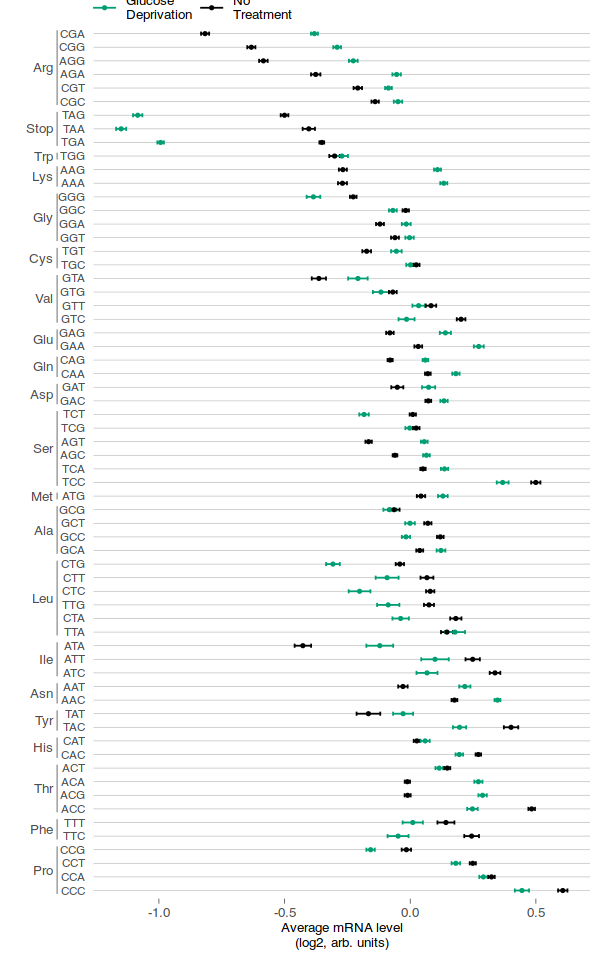

In [141]:
options(repr.plot.width = 5, repr.plot.height = 8)

aa_order <- c('Arg', 'Stop', 'Trp', 'Lys', 'Gly', 'Cys', 'Val', 'Glu', 'Gln', 'Asp', 'Ser', 'Met', 'Ala', 'Leu', 'Ile', 'Asn', 'Tyr', 'His', 'Thr', 'Phe', 'Pro')
AMINO_ACID_CODE["*"] = "Stop"

dicodon_plot_data <- bind_rows(codon_lfc_51, codon_lfc_78) %>%
  mutate(aa = AMINO_ACID_CODE[GENETIC_CODE[as.character(group)]]) %>%
  mutate(codon = str_c(group, ',', AMINO_ACID_CODE[GENETIC_CODE[as.character(group)]])) %>%
  arrange(factor(aa, levels = aa_order), lfc_2) %>%
  mutate(order_grp = 1:dplyr::n()) %>% 
  mutate(codon2 = fct_reorder(codon, -order_grp))
  
dicodon_plot_data %>%
  mutate(treatment = ifelse(treatment == 'No Treatment', 'No\nTreatment', 'Glucose\nDeprivation')) %>%
  filter(genotype == 'wild-type') %>%
  ggplot(aes(x = lfc_2, y = codon2,
             xmin = lfc_2 - lfc_sd, xmax = lfc_2 + lfc_sd,
             color=treatment
             )) +
  geom_errorbar(width=0.3) +
  geom_point(size=0.8) +
  scale_color_manual(values=c('No\nTreatment'='black', 
                              'Glucose\nDeprivation'='#009e73')) +
  scale_y_discrete(guide = guide_axis_nested(delim = ",")) +
  theme +
  theme(legend.position = "top",
        legend.justification='left',
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-10,-10,-10),
        panel.grid.major.y = element_line(color='grey', linewidth=0.2),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_text(size=7),
        ggh4x.axis.nestline = element_line(linewidth = 0.2),
        ggh4x.axis.nesttext.y = element_text(size=8),
        # strip.placement = "outside",
        # panel.spacing = unit(0.06, "lines"),
        # strip.background = element_rect(size = 0.1),
        # strip.text.y.left=element_text(angle=0)
        ) +
  labs(x = "Average mRNA level\n(log2, arb. units)", y = "",
       color='')

ggsave("../figures/fig3_bootstrapped_codon_effects_avg.pdf", width=2.6, height=7.5)

## Bootstrap by dipeptide

In [142]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna)) }

wt_diaa_lfc <- wt_e51 %>% 
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  mutate(treatment = "No Treatment") %>%
  mutate(genotype = 'WT')

hel2_diaa_lfc <- hel2_e67 %>% 
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  mutate(treatment = "No Treatment") %>%
  mutate(genotype = 'Hel2-del')

In [143]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna)) }

wt_nogluc_diaa_lfc <- wt_hel2_e78 %>% 
  filter(genotype == 'wt') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  mutate(treatment = "Glucose Deprivation") %>%
  mutate(genotype = 'WT')

hel2_nogluc_diaa_lfc <- wt_hel2_e78 %>% 
  filter(genotype == 'hel2') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  mutate(treatment = "Glucose Deprivation") %>%
  mutate(genotype = 'Hel2-del')

In [144]:
diaa_boot <- bind_rows(wt_diaa_lfc, hel2_diaa_lfc, wt_nogluc_diaa_lfc, hel2_nogluc_diaa_lfc)

In [145]:
wt_hel2_e78 %>%
    filter(genotype == 'wt') %>%
    group_by(diaa) %>%
    summarize(n=n()) %>%
    mutate(med = median(n)) %>%
    dplyr::slice(1) %>%
    select(-diaa, -n)

med
<int>
84


## Plot specific sets of dipeptides during glucose deprivation vs no-tx

In [146]:
sd_outliers <- diaa_boot %>%
    group_by(genotype, treatment) %>%
    mutate(iqr = IQR(lfc_sd)) %>%
    mutate(q3 = quantile(lfc_sd, c(0.75))) %>%
    dplyr::slice(1) %>%
    ungroup() %>%
    mutate(outlier = q3 + (iqr*1.5)) %>%
    select(genotype, treatment, iqr, outlier)

hel2_noglc_out_sd <- sd_outliers$outlier[[1]] + 0.05 # relax the sd filter a bit
hel2_notx_out_sd <- sd_outliers$outlier[[2]] + 0.05
wt_noglc_out_sd <- sd_outliers$outlier[[3]] + 0.05
wt_notx_out_sd <- sd_outliers$outlier[[4]] + 0.05

### Plot marking the dipeptides that are pulled out in WT data

In [147]:
select_diaa <- read_csv("../../wt_mrna_grna/tables/destabilized_wt.csv") %>%
    filter(Frame == "In-frame") %>%
    dplyr::pull(match_diaa)

Rows: 38 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Frame, match_diaa
dbl (4): lfc, lfc_sd, var, lfc_med

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


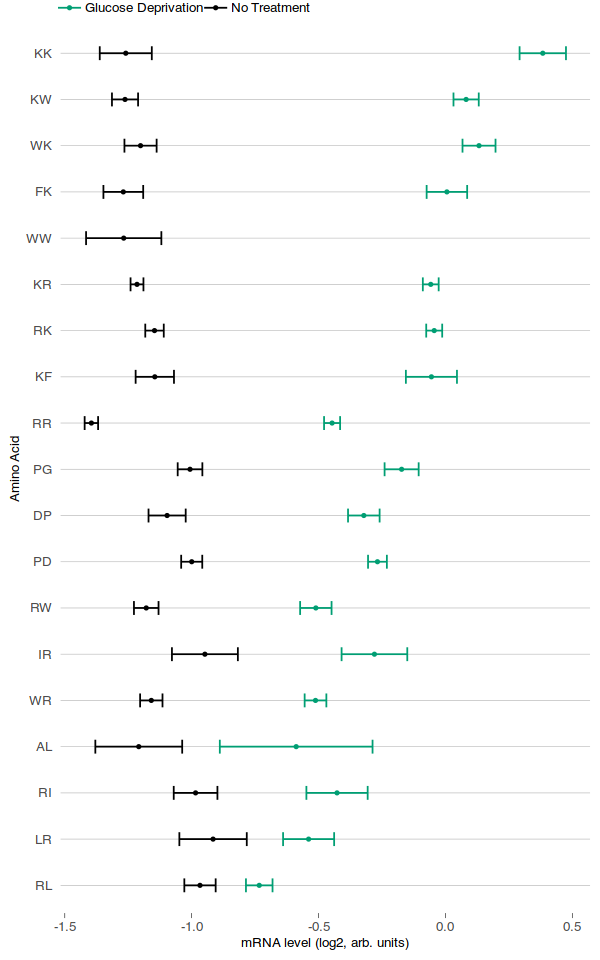

In [148]:
diaa_boot %>%
      filter(genotype == 'WT') %>%
      filter(diaa %in% select_diaa) %>% 
      complete(treatment, diaa) %>%
      mutate(missing = ifelse(is.na(lfc_2), 'missing', 'not_missing')) %>%
      mutate(lfc_2 = ifelse(is.na(lfc_2), 0, lfc_2)) %>%
      group_by(diaa) %>%
      mutate(order = rep(lfc_2[treatment == 'Glucose Deprivation'] - lfc_2[treatment == 'No Treatment'], 2)) %>%
      ungroup() %>%
      mutate(lfc_2 = ifelse(missing == 'missing', NA, lfc_2)) %>%
      mutate(diaa = fct_reorder(diaa, order)) %>%
      mutate(treatment = ifelse(treatment == 'No Treatment', 'No Treatment', 'Glucose Deprivation')) %>%
      ggplot(aes(x = lfc_2, y = diaa,
                  xmin = lfc_2 - lfc_sd, xmax = lfc_2 + lfc_sd,
                  color=treatment
                  )) +
      geom_errorbar(width=0.3) +
      geom_point(size=0.8) +
      scale_color_manual(values=c('No Treatment'='black', 
                              'Glucose Deprivation'='#009e73')) +
      theme +
      theme(legend.position = "top",
            legend.justification='left',
            legend.margin=margin(0,0,0,0),
            legend.box.margin=margin(-10,-5,-10,-8),
            legend.spacing.x = unit(0.25, 'mm'),
            panel.grid.major.y = element_line(color='grey', size=0.2),
            axis.line.x = element_blank(),
            axis.line.y = element_blank(),
            axis.ticks.y = element_blank(),
            # axis.text.x = element_text(angle=45, hjust=1, vjust=1)
            ) +
      labs(x = "mRNA level (log2, arb. units)", y = "Amino Acid",
            color='')

ggsave("../figures/wt_destabilized_diaa.pdf", width=3, height=2.85)

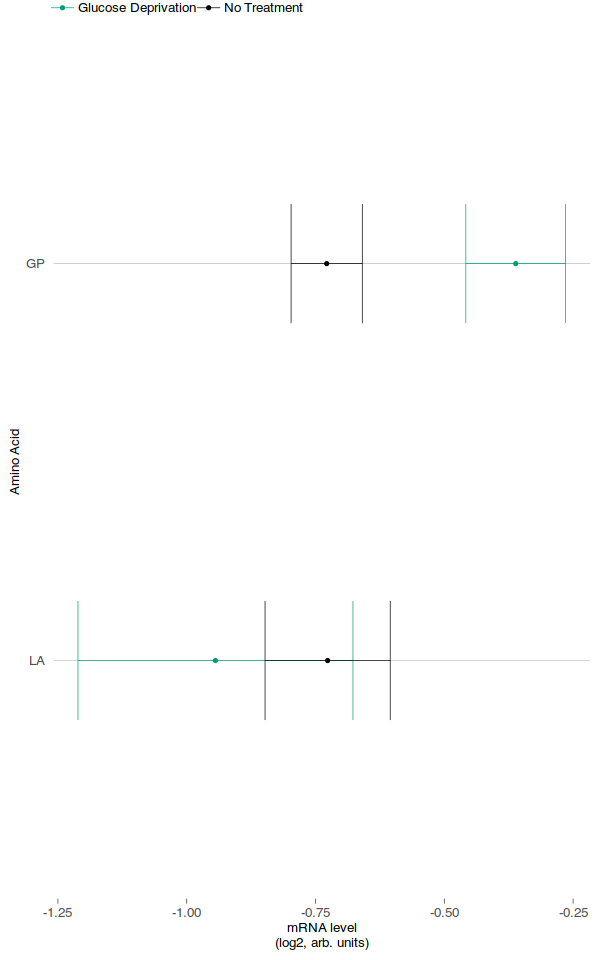

In [149]:
diaa_boot %>%
      filter(genotype == 'WT') %>%
      filter(diaa %in% c('GP', 'LA')) %>% 
      complete(treatment, diaa) %>%
      mutate(missing = ifelse(is.na(lfc_2), 'missing', 'not_missing')) %>%
      mutate(lfc_2 = ifelse(is.na(lfc_2), 0, lfc_2)) %>%
      group_by(diaa) %>%
      mutate(order = rep(lfc_2[treatment == 'Glucose Deprivation'] - lfc_2[treatment == 'No Treatment'], 2)) %>%
      ungroup() %>%
      mutate(lfc_2 = ifelse(missing == 'missing', NA, lfc_2)) %>%
      mutate(diaa = fct_reorder(diaa, order)) %>%
      mutate(treatment = ifelse(treatment == 'No Treatment', 'No Treatment', 'Glucose Deprivation')) %>%
      ggplot(aes(x = lfc_2, y = diaa,
                  xmin = lfc_2 - lfc_sd, xmax = lfc_2 + lfc_sd,
                  color=treatment
                  )) +
      geom_errorbar(width=0.3, linewidth=0.2) +
      geom_point(size=0.8) +
      scale_color_manual(values=c('No Treatment'='black', 
                              'Glucose Deprivation'='#009e73')) +
      theme +
      theme(legend.position = "top",
            legend.justification='left',
            legend.margin=margin(0,0,0,0),
            legend.box.margin=margin(-10,-5,-10,-8),
            legend.spacing.x = unit(0.25, 'mm'),
            panel.grid.major.y = element_line(color='grey', size=0.2),
            axis.line.x = element_blank(),
            axis.line.y = element_blank(),
            axis.ticks.y = element_blank(),
            # axis.text.x = element_text(angle=45, hjust=1, vjust=1)
            ) +
      labs(x = "mRNA level\n(log2, arb. units)", y = "Amino Acid",
            color='')

ggsave("../figures/wt_destabilized_diaa_gp.pdf", width=2.2, height=1.3)

## Plot frameshifted library vs CSC correlation

### Load sample annotations and barcode counts of frameshifted library

In [150]:
sample_annotations <- read_csv("../../wt_frameshifted_mrna_grna/annotations/sample_annotations.csv")

Rows: 2 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sample_id, index_primer, sample_name, sample_type, localization, li...
dbl (4): sample_num, barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [151]:
barcode_counts_frm <- list.files("../../wt_frameshifted_mrna_grna/data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 234451 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 212239 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [152]:
barcode_counts_frm %>%
    group_by(sample_name, insert_num) %>%
    summarize(n = n()) %>%
    mutate(avg = mean(n), med = median(n)) %>%
    dplyr::slice(1) %>%
    select(-insert_num, -n)

`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


sample_name,avg,med
<chr>,<dbl>,<dbl>
grna_cyto,40.15259,39
mrna_cyto,36.37967,36


In [153]:
barcode_counts_frm %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>%
  inner_join(insert_annotations, by='insert_num') %>%
  group_by(codon1) %>%
  summarize(n=n()) %>%
  mutate(avg = mean(n), med= median(n)) %>%
  dplyr::slice(1)

barcode_counts_frm %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>%
  inner_join(insert_annotations, by='insert_num') %>%
  group_by(codon2) %>%
  summarize(n=n()) %>%
  mutate(avg = mean(n), med= median(n)) %>%
  dplyr::slice(1)

codon1,n,avg,med
<chr>,<int>,<dbl>,<dbl>
AAA,2755,1855.625,1829.5


codon2,n,avg,med
<chr>,<int>,<dbl>,<dbl>
AAA,1823,1855.625,1840


### Bootstrap average codon level

In [154]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna_cyto)) - log2(sum(d$grna_cyto))
}

codon1_lfc <- barcode_counts_frm %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>%
  inner_join(insert_annotations, by='insert_num') %>%
  group_by(codon1) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 1) %>%
  dplyr::rename(codon = codon1) %>%
  mutate(lfc_2 = lfc - median(lfc))

codon2_lfc <- barcode_counts_frm %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>%
  inner_join(insert_annotations, by='insert_num') %>%
  group_by(codon2) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 2) %>%
  dplyr::rename(codon = codon2) %>%
  mutate(lfc_2 = lfc - median(lfc))

In [155]:
dicodon_plot_data <- bind_rows(codon1_lfc, codon2_lfc) %>%
  mutate(aa = AMINO_ACID_CODE[GENETIC_CODE[as.character(codon)]])

In [156]:
sc_coller <- read_csv("../../../../data/literature/forrest_2020/table_s2_data.csv", skip=3) %>% 
    select('Codon', 'Amino_Acid', 'SC_CSC', 'SC_AASC')

csc_aasc_lfc <- sc_coller %>%
    inner_join(dicodon_plot_data, by=c('Codon' = 'codon'))

Rows: 61 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Codon, Amino_Acid, HEK293_IsOpt, HeLa_IsOpt
dbl (26): HEK293_tAI, HeLa_tAI_1, HeLa_tAI_2, HeLa_tAI_3, HeLa_Avg_tAI, HeLa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


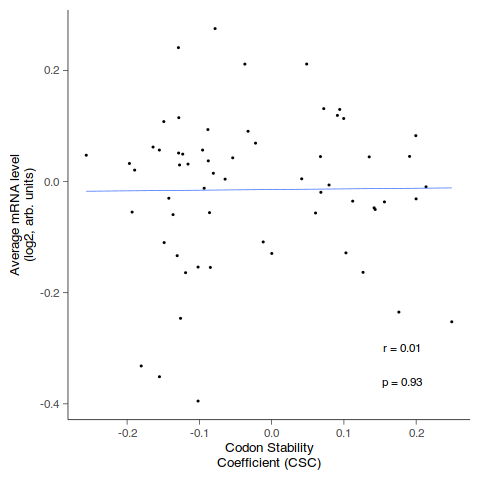

In [157]:
options(repr.plot.width=4, repr.plot.height=4)

plot_data <- csc_aasc_lfc %>%
    group_by(Codon) %>%
    mutate(avg_pos_lfc = mean(lfc_2)) %>%
    dplyr::slice(1) %>%
    mutate(name = str_c(Codon, " (", GENETIC_CODE[Codon], ")"))

pearson_r = cor(plot_data$SC_CSC, plot_data$avg_pos_lfc, method=c('pearson'))
p = cor.test(plot_data$SC_CSC, plot_data$avg_pos_lfc, method=c('pearson'))$p.value

plot_data %>%
    ggplot() +
    aes(x=SC_CSC, y=avg_pos_lfc) +
    geom_point(size=0.2) + 
    geom_smooth(method=lm, size=0.2, se=FALSE) +
    annotate('text',x=0.18, y=-0.30, size=7/.pt, label=str_c("r = ", round(pearson_r,2))) +
    annotate('text',x=0.18, y=-0.36, size=7/.pt, label=str_c('p = ', round(p, 2))) +
    theme +
    theme(
        axis.text.x=element_text(size=7),
        axis.text.y=element_text(size=7)
    ) +
    labs(x='Codon Stability\nCoefficient (CSC)', y='Average mRNA level\n(log2, arb. units)')

ggsave("../figures/fig3c_avg_lfc_coller_csc_correlation_lm_dicodons.pdf", width=1.8, height=1.75, units='in')

### Plot destabilized dipeptides in normal library vs frameshifted library

In [158]:
barcode_reads_cutoff <- 10
n_barcodes_cutoff <- 4

wt_frme <- barcode_counts_frm %>% # apply minor cutoffs as in exp51 analysis
    filter(barcode_count >= barcode_reads_cutoff) %>%
    mutate(genotype = 'WT') %>%
    mutate(library_type = str_extract(sample_name, '^[^_]+')) %>%
    group_by(genotype, library_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>% # filter out inserts that don't reach barcode rep cutoff while maintaining data as individual barcodes
    ungroup() %>%
    select(genotype, library_type, barcode_num, insert_num, barcode_count) %>%
    pivot_wider(names_from=c(library_type), values_from=barcode_count) %>%
    drop_na() %>%
    inner_join(insert_annotations, by='insert_num')

In [159]:
wt_frme %>%
    group_by(diaa) %>%
    summarize(n=n()) %>%
    mutate(med = median(n)) %>%
    dplyr::slice(1)

diaa,n,med
<chr>,<int>,<dbl>
**,154,196.5


In [160]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna)) }

wt_diaa_lfc_frm <- wt_frme %>% 
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  mutate(treatment = "Frameshifted") %>%
  mutate(genotype = 'WT')

In [161]:
diaa_boot_2 <- bind_rows(wt_diaa_lfc, wt_diaa_lfc_frm)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


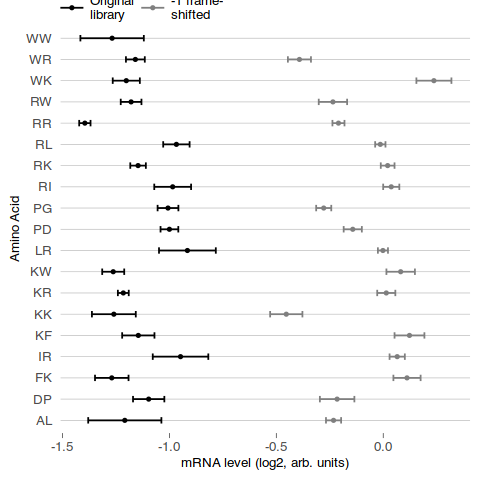

In [162]:
diaa_boot_2 %>%
    filter(genotype == 'WT') %>%
    filter(diaa %in% select_diaa) %>% 
    complete(treatment, diaa) %>%
    mutate(treatment = ifelse(treatment == 'No Treatment', 'Original\nlibrary', '-1 frame-\nshifted')) %>%
    mutate(treatment = factor(treatment, levels=c('Original\nlibrary', '-1 frame-\nshifted'))) %>%
    ggplot(aes(x = lfc_2, y = diaa,
                xmin = lfc_2 - lfc_sd, xmax = lfc_2 + lfc_sd,
                color=treatment
                )) +
    geom_errorbar(width=0.3) +
    geom_point(size=0.8) +
    scale_color_manual(values=c('Original\nlibrary'='black', 
                            '-1 frame-\nshifted'='grey50')) +
    theme +
    theme(legend.position = "top",
        legend.justification='left',
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-5,-10,-8),
        legend.spacing.x = unit(0.75, 'mm'),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        # axis.text.x = element_text(angle=45, hjust=1, vjust=1)
        ) +
    labs(x = "mRNA level (log2, arb. units)", y = "Amino Acid",
        color='')

ggsave("../figures/fig3_wt_destabilized_frme_diaa.pdf", width=1.85, height=2.7)

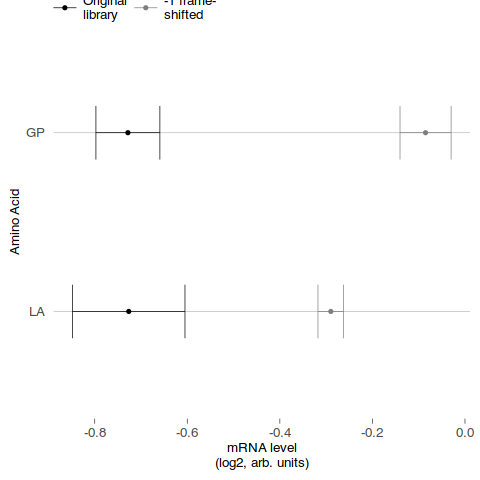

In [163]:
diaa_boot_2 %>%
    filter(genotype == 'WT') %>%
    filter(diaa %in% c('GP', 'LA')) %>% 
    complete(treatment, diaa) %>%
    mutate(treatment = ifelse(treatment == 'No Treatment', 'Original\nlibrary', '-1 frame-\nshifted')) %>%
    mutate(treatment = factor(treatment, levels=c('Original\nlibrary', '-1 frame-\nshifted'))) %>%
    mutate(diaa = fct_reorder(diaa, lfc_2)) %>%
    ggplot(aes(x = lfc_2, y = diaa,
                xmin = lfc_2 - lfc_sd, xmax = lfc_2 + lfc_sd,
                color=treatment
                )) +
    geom_errorbar(width=0.3, linewidth=0.2) +
    geom_point(size=0.8) +
    scale_color_manual(values=c('Original\nlibrary'='black', 
                            '-1 frame-\nshifted'='grey50')) +
    theme +
    theme(legend.position = "top",
        legend.justification='left',
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-5,-10,-8),
        legend.spacing.x = unit(0.75, 'mm'),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        # axis.text.x = element_text(angle=45, hjust=1, vjust=1)
        ) +
    labs(x = "mRNA level\n(log2, arb. units)", y = "Amino Acid",
        color='')

ggsave("../figures/sfig_wt_destabilized_frme_diaa_gp.pdf", width=1.9, height=1.3)